### Optimisation des modèles SGDClassifier

Le but de ce travail est d'estimer et trouver les meilleurs paramètres pour chaque modèle de classification de la famille des SGDClassifier

In [1]:
#chargement des librairies
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel,RFE,RFECV
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.preprocessing import 

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [306]:
### Préparation des données


def prep_input(df1,Xnum): #fonction qui standardise les données
    #Xcat=[]
    #lb=LabelBinarizer()
    rbs=RobustScaler()
    #for var in df1.select_dtypes('object'):
     #   Xcat.append(lb.fit_transform(df1[var]))
    Xcat_en=np.array(df1.select_dtypes('int64'))
    Xnum_en=rbs.fit_transform(Xnum)
    Xfeat=np.concatenate((Xcat_en,Xnum_en),axis=1)
    print(Xcat_en.shape,Xnum_en.shape,Xfeat.shape) #verification pour voir si tout s'est bien passee
    return Xfeat



## Selection des variables  pour chaaque modèle de la classe SGDClassifier avec la  methode RFECV (selection recursive):
def select_feat_sgdc(Xfeat,y,nbfeat,model,pen):
    selector=RFECV(SGDClassifier(loss=model,random_state=0,penalty=pen),step=1,min_features_to_select=nbfeat,cv=4)
    selector.fit(Xfeat,y)
    return selector.get_support() ,selector.ranking_,selector.grid_scores_


# Fonctions pour évaluer la performance de chaque modèle
def Vmatrice_confusion (cnf_matrix) :
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

def Performance(Y_test,Y_pred) :
    print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
    print("Precision:",metrics.precision_score(Y_test,Y_pred))
    print("Recall:",metrics.recall_score(Y_test,Y_pred))
    
def AUC(X_test,Y_test, model,typ) :
    Y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
    auc = metrics.roc_auc_score(Y_test, Y_pred_proba)
    plt.plot(fpr,tpr,label=f"{typ} model, AUC="+str(auc))
    plt.legend(loc=4)
    plt.show()

def SenSpe(confusion_matrix) :
    TN =confusion_matrix[0,0]
    TP =confusion_matrix[1,1]
    FP =confusion_matrix[0,1]
    FN =confusion_matrix[1,0]
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    speci = TN/(TN+FP)
    sensi = TP/(TP+FN)
    print ("Accuracy : ", round(accuracy*100,2),"%")
    print ("Sensibilité : ", round(sensi*100,2),"%")
    print ("Specificité: ", round(speci*100,2),"%")
    
    

In [3]:
list_model=['hinge', 'log', 'perceptron']
# hinge pour les supports vectors machines;
# log pour la regression logistique;
# perceptron utilise la fonction de perte linéaire des algorithmes de perceptron
pen=['l2','l1','elasticnet'] #Choix de la penalité
# l2 pour la norme quadratique,
# l1 pour la norme 1 sur R
# elasticnet combine les deux précédentes

In [4]:
df=pd.read_csv("E:/Projet_Stap/base_fin.csv") #importation de la base

In [5]:
df1=df.copy()

In [6]:
df1.columns

Index(['Unnamed: 0', 'host_platform', 'click_time', 'duplo_click_zone',
       'freeze_mode', 'click_time_origin', 'average_framerate',
       'last_second_framerate', 'viewability_time', 'device_type',
       'display_env', 'display_timestamp', 'contextid', 'navigationid',
       'is_coupon_visible', 'is_interstitial', 'nb_products_in_banner',
       'confirmed', 'revclick_x', 'revclick_y', 'Surface_B', 'device_type2',
       'display_env2', 'contextid2', 'duplo_click_zone2', 'duplo_click_zone3',
       'navigationid2', 'nb_products_in_banner2', 'timestamp1', 'Jour', 'Mois',
       'heurecomplet', 'heure', 'Annee', 'heure2', 'host_platformEU',
       'host_platformAS', 'host_platformUS', 'device_type2Android',
       'device_type2iPhone', 'device_type2Autres', 'display_env2web',
       'display_env2app_android', 'display_env2app_ios', 'contextid2[4,7[',
       'contextid27 et +', 'contextid2[0,4[',
       'duplo_click_zone2Banner parts - Containers',
       'duplo_click_zone2Text fiel

In [7]:
# sélection des variables traitées pour le travail
df1=df1[['click_time',
       'freeze_mode', 'click_time_origin', 'average_framerate',
       'last_second_framerate', 'viewability_time',
       'is_coupon_visible', 'is_interstitial',
       'confirmed', 'revclick_x', 'revclick_y', 'Surface_B','host_platformEU',
       'host_platformAS', 'host_platformUS', 'device_type2Android',
       'device_type2iPhone', 'device_type2Autres', 'display_env2web',
       'display_env2app_android', 'display_env2app_ios', 'contextid2[4,7[',
       'contextid27 et +', 'contextid2[0,4[', 'navigationid2Neutral',
       'navigationid2Scrolling', 'navigationid2Slideshow',
       'navigationid2Slideshow with arrow/dots', 'nb_products_in_banner2[3,7[',
       'nb_products_in_banner212 et plus', 'nb_products_in_banner2[7,12[',
       'nb_products_in_banner2[1,3[', 'JourSun ', 'JourSat ', 'JourFri ',
       'JourThu ', 'JourWed ', 'JourTue ', 'JourMon ', 'duplo_click_zone34',
       'duplo_click_zone3Autres', 'duplo_click_zone35', 'duplo_click_zone32',
       'duplo_click_zone36', 'heure2Soir', 'heure2ApresMidi', 'heure2Matin',
       'heure2[00, 12h[']]

In [8]:
df1.dtypes

click_time                                float64
freeze_mode                                 int64
click_time_origin                         float64
average_framerate                         float64
last_second_framerate                     float64
viewability_time                          float64
is_coupon_visible                           int64
is_interstitial                             int64
confirmed                                  object
revclick_x                                float64
revclick_y                                float64
Surface_B                                 float64
host_platformEU                             int64
host_platformAS                             int64
host_platformUS                             int64
device_type2Android                         int64
device_type2iPhone                          int64
device_type2Autres                          int64
display_env2web                             int64
display_env2app_android                     int64


In [9]:
var_num=[var for var in df1.select_dtypes('float64')]

In [10]:
## Preparation des donnees standardisation
Xfeat=prep_input(df1,df1[var_num])

(589868, 39) (589868, 8) (589868, 47)


In [13]:
encoder=LabelEncoder()
y=encoder.fit_transform(df1['confirmed']) #encodage pour la variable cible

In [14]:
#selection des variables pour chaque modele avec la methode RFECV
modeles={}
for modele in list_model:
    modeles[modele]={}
    for penal in pen:
        modeles[modele][penal]=select_feat_sgdc(Xfeat,y,20,modele,penal) 
        #var_sel[modele],rank[modele],scor[modele]=select_feat_sgdc(Xfeat,y,20,modele,penal) 

In [15]:
var_int=[var for var in df1.select_dtypes('int64')]
var_float=[var for var in df1.select_dtypes('float')]
var_fi=var_int+var_float 

In [16]:
base=pd.DataFrame(Xfeat,columns=var_fi) # On construit un dataframe suivant l'ordre des variables dans Xfeat pour 
                                        # avoir la liste des variables retenues pour estimer le modèle

### Support Vector Machine 

Pour chaque pénalité, on regarde les variables choisies

In [24]:
def Varselect(model,penal):   
    plt.plot(range(1,len(modeles[model][penal][2])+1),modeles[model][penal][2])
    plt.title(f"gain d'information en fonction du nombre de variables eliminées pour la pénalité {penal}")
    plt.show()
    print(f"On voulait retenir au minimum 20 variables, l'algorithmes en a retenu {list(modeles[model][penal][0]).count(True)}")
    return list(base.columns[modeles[model][penal][0]])  


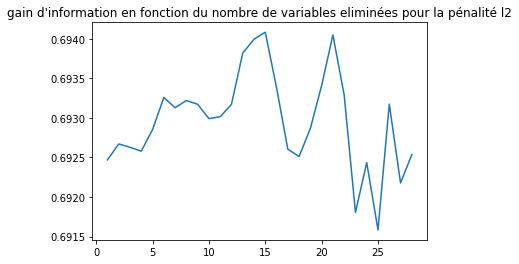

On voulait retenir au minimum 20 variables, l'algorithmes en a retenu 34


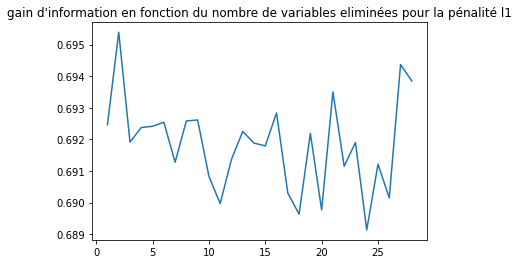

On voulait retenir au minimum 20 variables, l'algorithmes en a retenu 21


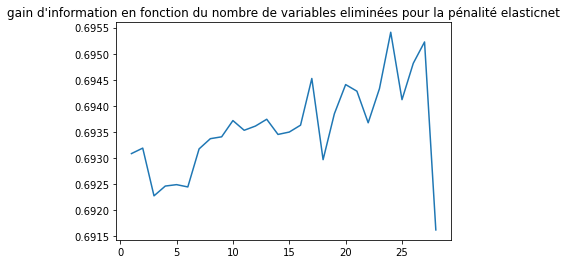

On voulait retenir au minimum 20 variables, l'algorithmes en a retenu 43


In [53]:
## Pour chaque pénalité, on va voir regarde les variables choisies pour le svm
var_hinge={}
for penal in pen:
    var_hinge[penal]=Varselect('hinge',penal)

### Pour chaque pénalité, on va estimer et trouver les parametres optimaux pour le modele avec les variables choisies 

In [54]:
def base_model(list_var):
    base['confirmed']=df1['confirmed']
    list_var.append('confirmed')
    base_f=base[list_var]
    ### Equilibre de la base
    base_fc= base_f[base_f['confirmed']=="confirm"]
    base_fnc= base_f[base_f['confirmed']=="Nconfirm"]
    base_fnc= base_fnc.sample(n=base_fc.shape[0], replace = False)
    df = base_fc.append(base_fnc)
    return(df)        

In [55]:
df_svm1=base_model(var_hinge['l1'])
df_svm2=base_model(var_hinge['l2'])
df_svm3=base_model(var_hinge['elasticnet'])

In [56]:
# verification 
df_svm1.dtypes

freeze_mode                               float64
is_interstitial                           float64
host_platformAS                           float64
device_type2iPhone                        float64
device_type2Autres                        float64
display_env2web                           float64
display_env2app_ios                       float64
contextid27 et +                          float64
contextid2[0,4[                           float64
navigationid2Neutral                      float64
navigationid2Slideshow                    float64
navigationid2Slideshow with arrow/dots    float64
nb_products_in_banner2[3,7[               float64
nb_products_in_banner212 et plus          float64
nb_products_in_banner2[1,3[               float64
JourMon                                   float64
duplo_click_zone32                        float64
heure2[00, 12h[                           float64
average_framerate                         float64
last_second_framerate                     float64


In [57]:
# verification 
df_svm2.dtypes

freeze_mode                               float64
is_interstitial                           float64
host_platformEU                           float64
host_platformAS                           float64
device_type2Android                       float64
device_type2iPhone                        float64
device_type2Autres                        float64
display_env2web                           float64
display_env2app_ios                       float64
contextid2[4,7[                           float64
contextid27 et +                          float64
contextid2[0,4[                           float64
navigationid2Neutral                      float64
navigationid2Scrolling                    float64
navigationid2Slideshow                    float64
navigationid2Slideshow with arrow/dots    float64
nb_products_in_banner2[3,7[               float64
nb_products_in_banner212 et plus          float64
nb_products_in_banner2[7,12[              float64
nb_products_in_banner2[1,3[               float64


In [58]:
# verification 
df_svm3.dtypes

freeze_mode                               float64
is_coupon_visible                         float64
is_interstitial                           float64
host_platformEU                           float64
host_platformAS                           float64
host_platformUS                           float64
device_type2Android                       float64
device_type2iPhone                        float64
device_type2Autres                        float64
display_env2web                           float64
display_env2app_android                   float64
display_env2app_ios                       float64
contextid2[4,7[                           float64
contextid27 et +                          float64
navigationid2Neutral                      float64
navigationid2Scrolling                    float64
navigationid2Slideshow                    float64
navigationid2Slideshow with arrow/dots    float64
nb_products_in_banner2[3,7[               float64
nb_products_in_banner212 et plus          float64


In [126]:
df_svm1.to_csv("E:/Projet_Stap/df_svm1.csv")
df_svm2.to_csv("E:/Projet_Stap/df_svm2.csv")
df_svm3.to_csv("E:/Projet_Stap/df_svm3.csv")

In [64]:
def estim_optim(df,model,pen,params_grid):
    y=encoder.fit_transform(df['confirmed'])
    X=df.drop(['confirmed'], axis=1)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
    print("Echantillon d'entrainement: " ,X_train.shape)
    print("Echantillon de test: " ,X_test.shape)
    grid=GridSearchCV(SGDClassifier(loss=model,penalty=pen),params_grid,cv=5)
    grid.fit(X_train,y_train) # entrainement du modele
    return grid.best_params_,grid.best_estimator_,X_test,y_test # On retourne les meilleurs parametres et le modele correspondant

In [65]:
params_grid={'alpha':[0.0001,0.001,0.01,0.1,1],'epsilon':[0.01,0.1,0.5],'eta0':[0.01,0.1,0.5],'power_t':[0.5,0.25,0.33],
             'learning_rate':['optimal','invscaling','adaptive'],'validation_fraction':[0.1,0.4,0.6,0.8]}
# definition des hyperparametres a optimiser pour le modele svm l1 et l2

### SVM avec L1

In [66]:
psvm1,model_svm1,Xtest,ytest=estim_optim(df_svm1,'hinge','l1',params_grid)

Echantillon d'entrainement:  (283607, 21)
Echantillon de test:  (121547, 21)


In [67]:
psvm1

{'alpha': 0.0001,
 'epsilon': 0.1,
 'eta0': 0.01,
 'learning_rate': 'invscaling',
 'power_t': 0.5,
 'validation_fraction': 0.4}

Accuracy: 0.6925057796572519
Precision: 0.6648583820268593
Recall: 0.7813268215936281
Accuracy :  69.25 %
Sensibilité :  78.13 %
Specificité:  60.3 %


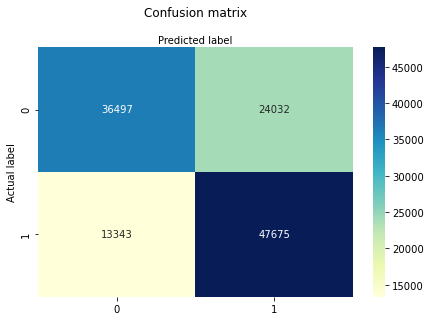

In [72]:
cnf_matrix=confusion_matrix(ytest, model_svm1.predict(Xtest))
Y_pred=model_svm1.predict(Xtest)
Vmatrice_confusion (cnf_matrix)    
Performance(ytest,Y_pred)
SenSpe(cnf_matrix)
#AUC(Xtest,ytest,model_svm1,'svm_l1') 

On diminue les hyperparametres pour le second modele pour gagner en temps 

### SVM avec L2

In [85]:
params_grid={'epsilon':[0.01,0.1,0.5],'eta0':[0.01,0.1,0.5],'power_t':[0.5,0.25,0.33],'learning_rate':['optimal','invscaling','adaptive'],'validation_fraction':[0.1,0.4,0.6,0.8]}

In [87]:
psvm2,model_svm2,Xtest2,ytest2=estim_optim(df_svm2,'hinge','l2',params_grid)

Echantillon d'entrainement:  (283607, 34)
Echantillon de test:  (121547, 34)


In [88]:
psvm2

{'epsilon': 0.01,
 'eta0': 0.5,
 'learning_rate': 'optimal',
 'power_t': 0.33,
 'validation_fraction': 0.1}

Accuracy: 0.6911318255489646
Precision: 0.657464048078987
Recall: 0.8032056114589138
Accuracy :  69.11 %
Sensibilité :  80.32 %
Specificité:  57.82 %


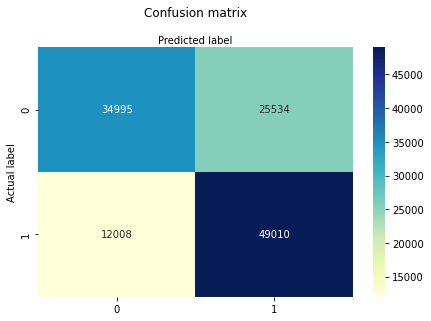

In [90]:
cnf_matrix=confusion_matrix(ytest2, model_svm2.predict(Xtest2))
Y_pred=model_svm2.predict(Xtest2)
Vmatrice_confusion (cnf_matrix)    
Performance(ytest2,Y_pred)
SenSpe(cnf_matrix)
#AUC(Xtest,ytest,model_svm1,'svm_l1') 

### SVM avec elasticnet

In [91]:
params_grid={'l1_ratio':[0.15, 0.3,0.5,0.7,0.9],'epsilon':[0.01,psvm3,model_svm3,Xtest3,ytest3=estim_optim(df_svm3,'hinge','elasticnet',params_grid)0.1,0.5],'eta0':[0.01,0.1,0.5],'power_t':[0.5,0.25,0.33],'learning_rate':['optimal','invscaling','adaptive'],'validation_fraction':[0.1,0.4,0.6,0.8]}

In [92]:
psvm3,model_svm3,Xtest3,ytest3=estim_optim(df_svm3,'hinge','elasticnet',params_grid)

Echantillon d'entrainement:  (283607, 43)
Echantillon de test:  (121547, 43)


In [93]:
psvm3

{'epsilon': 0.5,
 'eta0': 0.01,
 'l1_ratio': 0.3,
 'learning_rate': 'optimal',
 'power_t': 0.33,
 'validation_fraction': 0.6}

Accuracy: 0.6953688696553596
Precision: 0.6671310938653812
Recall: 0.7847192631682455
Accuracy :  69.54 %
Sensibilité :  78.47 %
Specificité:  60.53 %


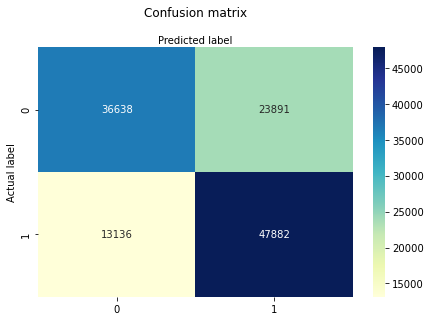

In [94]:
cnf_matrix=confusion_matrix(ytest3, model_svm3.predict(Xtest3))
Y_pred=model_svm3.predict(Xtest3)
Vmatrice_confusion (cnf_matrix)    
Performance(ytest3,Y_pred)
SenSpe(cnf_matrix)
#AUC(Xtest,ytest,model_svm1,'svm_l1') 

Il n'observe pas de différence majeures entre les performances de ces modèles.
le SVM avec la pénalité l1 a cependant besoin de moins de variables (moins de la moitié que le SVM avec elasticnet)

### Regression Logistique

In [74]:
base.drop(['confirmed'], axis=1,inplace=True)

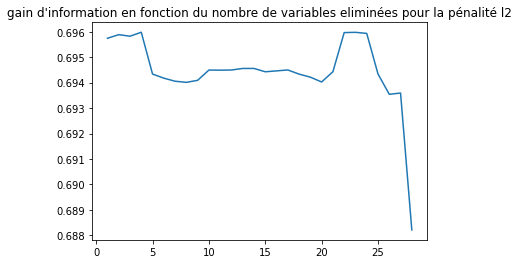

On voulait retenir au minimum 20 variables, l'algorithmes en a retenu 23


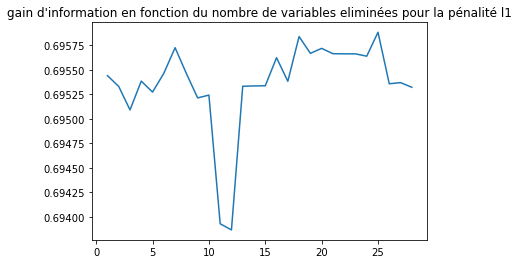

On voulait retenir au minimum 20 variables, l'algorithmes en a retenu 44


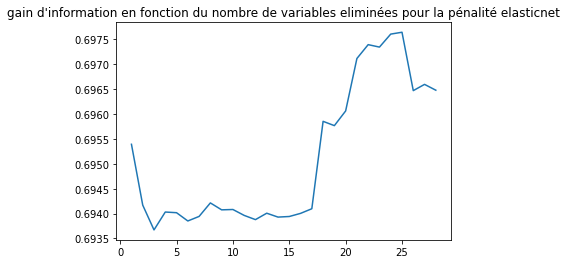

On voulait retenir au minimum 20 variables, l'algorithmes en a retenu 44


In [75]:
var_log={}
for penal in pen:
    var_log[penal]=Varselect('log',penal)

In [76]:
df_log1=base_model(var_log['l1'])
df_log2=base_model(var_log['l2'])
df_log3=base_model(var_log['elasticnet'])

In [77]:
import csv 
df_log1.to_csv("E:/Projet_Stap/df_log1.csv")
df_log2.to_csv("E:/Projet_Stap/df_log2.csv")
df_log3.to_csv("E:/Projet_Stap/df_log3.csv")

#### Regression Logistique avec la penalite L1

In [95]:
params_grid={'epsilon':[0.01,0.1,0.5],'eta0':[0.01,0.1,0.5],'power_t':[0.5,0.25,0.33],'learning_rate':['optimal','invscaling','adaptive'],'validation_fraction':[0.1,0.4,0.6,0.8]}

In [96]:
plog1,model_log1,Xtest4,ytest4=estim_optim(df_log1,'log','l1',params_grid)

Echantillon d'entrainement:  (283607, 44)
Echantillon de test:  (121547, 44)


In [97]:
plog1

{'epsilon': 0.01,
 'eta0': 0.01,
 'learning_rate': 'adaptive',
 'power_t': 0.25,
 'validation_fraction': 0.4}

Accuracy: 0.6939455519264153
Precision: 0.6749008665002203
Recall: 0.7531220295650464
Accuracy :  69.39 %
Sensibilité :  75.31 %
Specificité:  63.43 %


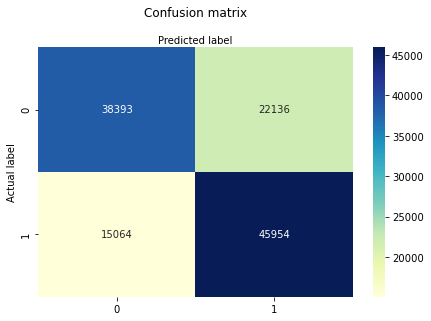

In [99]:
cnf_matrix=confusion_matrix(ytest4, model_log1.predict(Xtest4))
Y_pred=model_log1.predict(Xtest4)
Vmatrice_confusion (cnf_matrix)    
Performance(ytest4,Y_pred)
SenSpe(cnf_matrix)

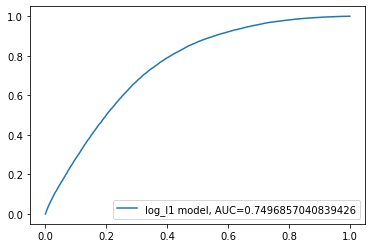

In [100]:
AUC(Xtest4,ytest4,model_log1,'log_l1') 

#### Regression Logistique avec la penalite L2

In [101]:
plog2,model_log2,Xtest5,ytest5=estim_optim(df_log2,'log','l2',params_grid)

Echantillon d'entrainement:  (283607, 23)
Echantillon de test:  (121547, 23)


In [102]:
plog2

{'epsilon': 0.1,
 'eta0': 0.5,
 'learning_rate': 'optimal',
 'power_t': 0.5,
 'validation_fraction': 0.4}

Accuracy: 0.6911729618995122
Precision: 0.6715719943298893
Recall: 0.753138418171687
Accuracy :  69.12 %
Sensibilité :  75.31 %
Specificité:  62.87 %


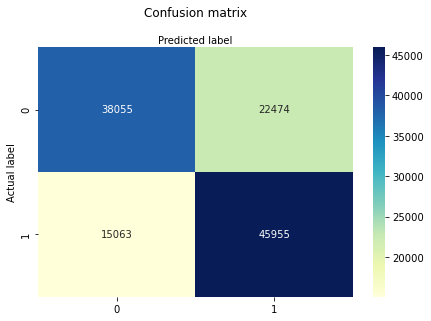

In [104]:
cnf_matrix=confusion_matrix(ytest5, model_log2.predict(Xtest5))
Y_pred=model_log2.predict(Xtest5)
Vmatrice_confusion (cnf_matrix)    
Performance(ytest5,Y_pred)
SenSpe(cnf_matrix)

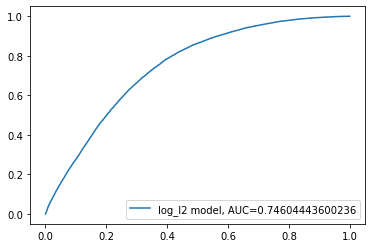

In [105]:
AUC(Xtest5,ytest5,model_log2,'log_l2') 

#### Regression Logistique avec la penalite elasticnet

In [107]:
params_grid={'l1_ratio':[0.15, 0.3,0.5,0.7,0.9],'epsilon':[0.01,0.1,0.5],'eta0':[0.01,0.1,0.5],'power_t':[0.5,0.25,0.33],'learning_rate':['optimal','invscaling','adaptive'],'validation_fraction':[0.1,0.4,0.6,0.8]}

In [109]:
plog3,model_log3,Xtest6,ytest6=estim_optim(df_log3,'log','elasticnet',params_grid)

Echantillon d'entrainement:  (283607, 44)
Echantillon de test:  (121547, 44)


In [110]:
plog3

{'epsilon': 0.1,
 'eta0': 0.5,
 'l1_ratio': 0.5,
 'learning_rate': 'invscaling',
 'power_t': 0.5,
 'validation_fraction': 0.8}

Accuracy: 0.6957802331608349
Precision: 0.6769203597132891
Recall: 0.7537447966173916
Accuracy :  69.58 %
Sensibilité :  75.37 %
Specificité:  63.73 %


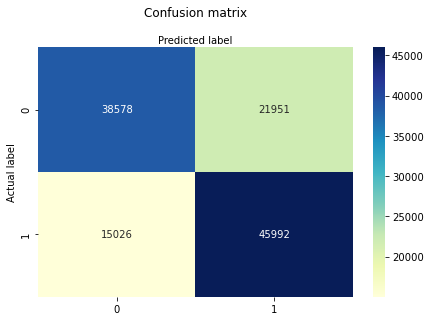

In [111]:
cnf_matrix=confusion_matrix(ytest6, model_log3.predict(Xtest6))
Y_pred=model_log3.predict(Xtest6)
Vmatrice_confusion (cnf_matrix)    
Performance(ytest6,Y_pred)
SenSpe(cnf_matrix)

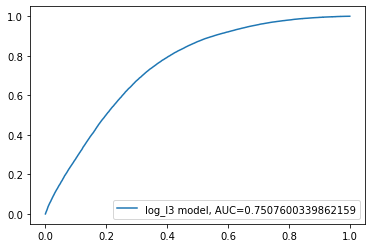

In [112]:
AUC(Xtest6,ytest6,model_log3,'log_l3') 

 Tout comme avec les SVM il n'y a pas de grande différences entre ces modèles du point de vu des performances. Mais on note aussi que le modèle avec l2 nécessite moins de variables que les 2 autres
Les courbes d'apprentissage nous apprendront plus sur la stabilité de ces modèles

### Perceptron

In [78]:
base.drop(['confirmed'], axis=1,inplace=True)

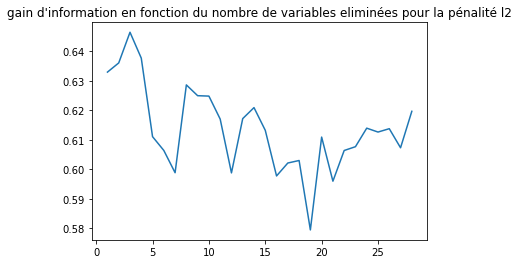

On voulait retenir au minimum 20 variables, l'algorithmes en a retenu 22


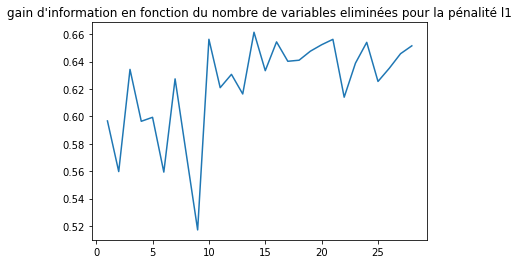

On voulait retenir au minimum 20 variables, l'algorithmes en a retenu 33


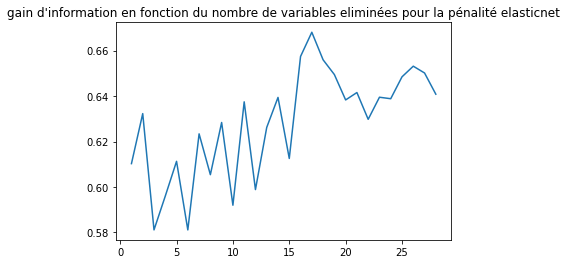

On voulait retenir au minimum 20 variables, l'algorithmes en a retenu 36


In [82]:
var_per={}
for penal in pen:
    var_per[penal]=Varselect('perceptron',penal)

In [83]:
df_per1=base_model(var_per['l1'])
df_per2=base_model(var_per['l2'])
df_per3=base_model(var_per['elasticnet'])

In [84]:
df_per1.to_csv("E:/Projet_Stap/df_per1.csv")
df_per2.to_csv("E:/Projet_Stap/df_per2.csv")
df_per3.to_csv("E:/Projet_Stap/df_per3.csv")

### Perceptron avec l1

In [113]:
params_grid={'epsilon':[0.01,0.1,0.5],'eta0':[0.01,0.1,0.5],'power_t':[0.5,0.25,0.33],'learning_rate':['optimal','invscaling','adaptive'],'validation_fraction':[0.1,0.4,0.6,0.8]}

In [114]:
percpam1,model_perc1,Xtest7,ytest7=estim_optim(df_per1,'perceptron','l1',params_grid)

Echantillon d'entrainement:  (283607, 33)
Echantillon de test:  (121547, 33)


In [115]:
percpam1

{'epsilon': 0.01,
 'eta0': 0.1,
 'learning_rate': 'optimal',
 'power_t': 0.5,
 'validation_fraction': 0.1}

Accuracy: 0.5882086764790575
Precision: 0.6352891827872088
Recall: 0.4219574551771608
Accuracy :  58.82 %
Sensibilité :  42.2 %
Specificité:  75.58 %


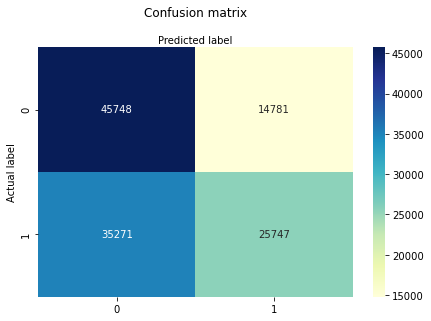

In [117]:
cnf_matrix=confusion_matrix(ytest7, model_perc1.predict(Xtest7))
Y_pred=model_perc1.predict(Xtest7)
Vmatrice_confusion (cnf_matrix)    
Performance(ytest7,Y_pred)
SenSpe(cnf_matrix)

### Perceptron avec l2

In [118]:
percpam2,model_perc2,Xtest8,ytest8=estim_optim(df_per2,'perceptron','l2',params_grid)

Echantillon d'entrainement:  (283607, 22)
Echantillon de test:  (121547, 22)


In [119]:
percpam2

{'epsilon': 0.1,
 'eta0': 0.1,
 'learning_rate': 'optimal',
 'power_t': 0.25,
 'validation_fraction': 0.4}

Accuracy: 0.5610340033073626
Precision: 0.6094120334675462
Recall: 0.3497492543183979
Accuracy :  56.1 %
Sensibilité :  34.97 %
Specificité:  77.4 %


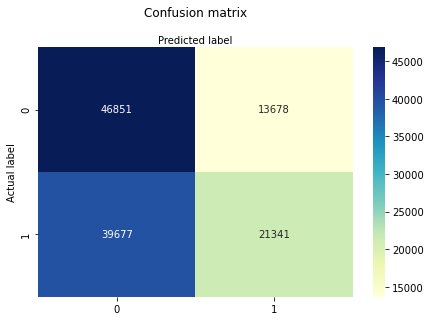

In [120]:
cnf_matrix=confusion_matrix(ytest8, model_perc2.predict(Xtest8))
Y_pred=model_perc2.predict(Xtest8)
Vmatrice_confusion (cnf_matrix)    
Performance(ytest8,Y_pred)
SenSpe(cnf_matrix)

### Perceptron avec elasticnet

In [121]:
percpam3,model_perc3,Xtest9,ytest9=estim_optim(df_per3,'perceptron','elasticnet',params_grid)

Echantillon d'entrainement:  (283607, 36)
Echantillon de test:  (121547, 36)


In [122]:
percpam3

{'epsilon': 0.01,
 'eta0': 0.01,
 'learning_rate': 'adaptive',
 'power_t': 0.5,
 'validation_fraction': 0.1}

Accuracy: 0.6371527063605025
Precision: 0.6044226044226044
Recall: 0.8022878494870366
Accuracy :  63.72 %
Sensibilité :  80.23 %
Specificité:  47.07 %


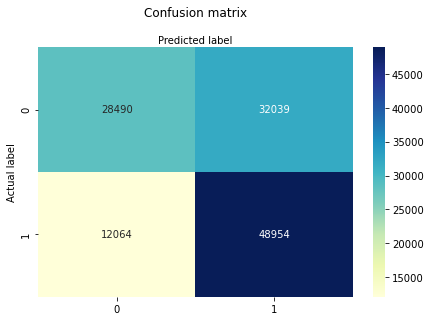

In [123]:
cnf_matrix=confusion_matrix(ytest9, model_perc3.predict(Xtest9))
Y_pred=model_perc3.predict(Xtest9)
Vmatrice_confusion (cnf_matrix)    
Performance(ytest9,Y_pred)
SenSpe(cnf_matrix)

Les deux premiers modèles de perceptron ont des spécificités au delà de 75%; et des sensibilités inférieures à 43%.
Ces deux modèles ont donc tentance à mieux prédire les clics accidentels. A l'inverse; le dernier modèle des perceptrons ( pénalité elasticnet )
a une sensibilité de 80% contre une spécificité de 47,7%. Contrairement aux deux premiers; il prédit mieux les clics non accidentels

### VISUALISATION DU SCORE DES REGRESSIONS LOGISTIQUES EN FONCTION DE LA TAILLE DES DONNEES (COURBES D'APPRENTISSAGE)

In [227]:
def learningcurve(df,model):
    y=encoder.fit_transform(df['confirmed'])
    X=df.drop(['confirmed'], axis=1)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
    N,train_score,val_score=learning_curve(model,X_train,y_train,train_sizes=np.linspace(0.2,1,30),cv=4)
    plt.plot(N,train_score.mean(axis=1),label='train')
    plt.plot(N,val_score.mean(axis=1),label='validation')
    plt.xlabel('train_sizes')
    plt.legend()

### Pour la regression logistique avec l1

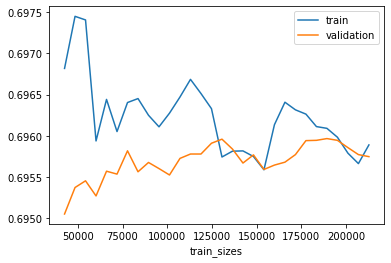

In [228]:
learningcurve(df_log1,model_log1)

### Pour la regression logistique avec l2

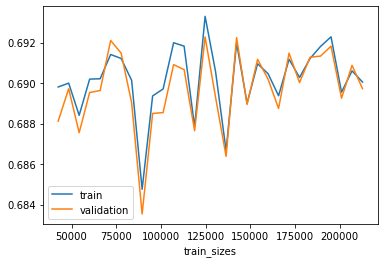

In [229]:
learningcurve(df_log2,model_log2)

### Pour la regression logistique avec elasticnet

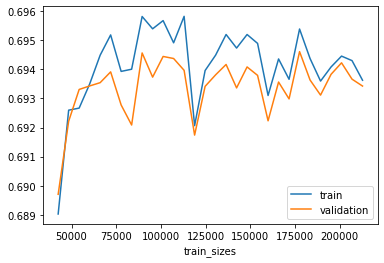

In [230]:
learningcurve(df_log3,model_log3)

Les coubes d'apprentissage montrent que les moodèles de régressions logistiques implementées ne sont pas très stables , en effet, les courbes d'apprentissage fluctuent beaucoup avec la taille de l'échantillon. Cependant; le graphe associé au premier modèle (pénalité l1) nous fait penser que celui-ci est préferable aux deux autres

### Pour les SVM avec L1

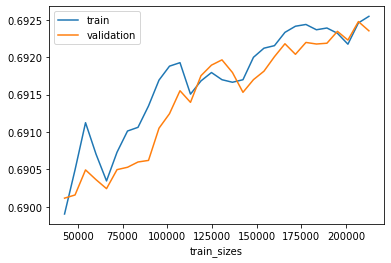

In [231]:
learningcurve(df_svm1,model_svm1)

In [ ]:
### Pour les SVM avec L2

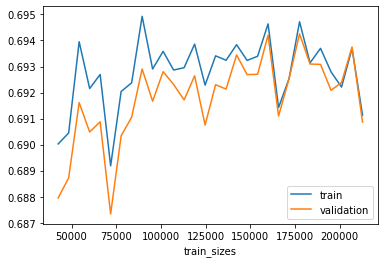

In [232]:
learningcurve(df_svm2,model_svm2)

In [ ]:
### Pour les SVM avec elasticnet

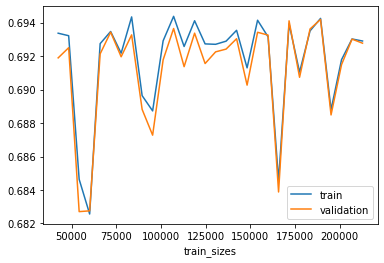

In [234]:
learningcurve(df_svm3,model_svm3)

Preferable de conserver svm avec l1 et logistique avec l1 car il est le modèle le plus stable. Cependant; il nous est pas possible de calculer les probalilités prédictes avec ce modèle; nous allons donc nous contenter du modèle de regréssion logistique avec la pénalité l1 pour ce faire 

calcul des probabilites predictes avec model_log1

In [237]:
var_feat=df_log1.columns.tolist()
var_feat.remove('confirmed')

In [238]:
Y_prob=model_log1.predict_proba(base[var_feat])

In [248]:
Y_prob[:,1:2][0]

array([0.78475304])

In [250]:
base_prob=pd.DataFrame(Y_prob)

In [251]:
base_prob.head()

,0,1
0,0.215247,0.784753
1,0.219882,0.780118
2,0.270942,0.729058
3,0.223633,0.776367
4,0.214094,0.785906


In [253]:
base=pd.concat([base,base_prob],axis=1)
base.to_csv("E:/Projet_Stap/base_with_prob")

In [257]:
coefs={}
coef=model_log1.coef_.tolist()
for i,var in  enumerate(var_feat):
    coefs[var]=coef[0][i]   

In [258]:
tab_coef=pd.DataFrame.from_dict(coefs,orient='index')

In [260]:
tab_coef.to_csv("E:/Projet_Stap/tab_coef_log_l1")

In [261]:
base_p=base[['confirmed',0,1]]

In [262]:
base_p.head(25)

,confirmed,0,1
0,Nconfirm,0.215247,0.784753
1,Nconfirm,0.219882,0.780118
2,Nconfirm,0.270942,0.729058
3,confirm,0.223633,0.776367
4,Nconfirm,0.214094,0.785906
5,Nconfirm,0.862838,0.137162
6,Nconfirm,0.232230,0.767770
7,Nconfirm,0.194124,0.805876
8,confirm,0.233785,0.766215
9,confirm,0.489530,0.510470


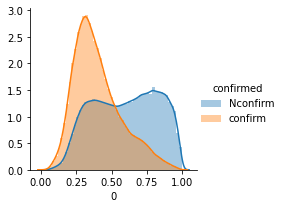

In [263]:
g = sns.FacetGrid(data=base_p, hue='confirmed')
g.map(sns.distplot, 0).add_legend()
plt.show()

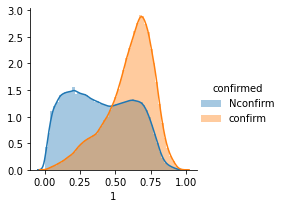

In [264]:
g = sns.FacetGrid(data=base_p, hue='confirmed')
g.map(sns.distplot, 1).add_legend()
plt.show()

In [273]:
base_p[(base_p[1]>0.6) & (base_p['confirmed']=='Nconfirm')].shape

(92585, 3)

In [275]:
base_p[(base_p[1]<0.5) & (base_p['confirmed']=='confirm')].shape

(49579, 3)

In [276]:
bf=base[(base[1]>0.6) & (base['confirmed']=='Nconfirm')]

In [280]:
base_p[(base_p[1]>0.95) & (base_p['confirmed']=='Nconfirm')].shape

(9, 3)

Text(0.5, 0, 'probabilité avec laquelle le modèle a prédit comme clic non accidentel')

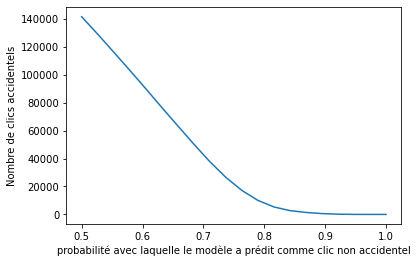

In [284]:
X=np.linspace(0.5,1,20)
y=[]
for i,x in enumerate(X):
    y.append(base_p[(base_p[1]>=x) & (base_p['confirmed']=='Nconfirm')].shape[0])
plt.plot(X,y)
plt.ylabel("Nombre de clics accidentels")
plt.xlabel("probabilité avec laquelle le modèle a prédit comme clic non accidentel")

Text(0.5, 0, 'probabilité avec laquelle le modèle a prédit comme clic  accidentel')

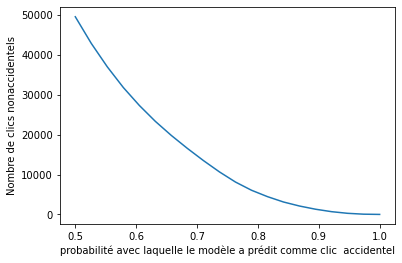

In [285]:
X=np.linspace(0.5,1,20)
y=[]
for i,x in enumerate(X):
    y.append(base_p[(base_p[0]>=x) & (base_p['confirmed']=='confirm')].shape[0])
plt.plot(X,y)
plt.ylabel("Nombre de clics nonaccidentels")
plt.xlabel("probabilité avec laquelle le modèle a prédit comme clic  accidentel")

Text(0.5, 0, 'probabilité avec laquelle le modèle a prédit comme clic non accidentel')

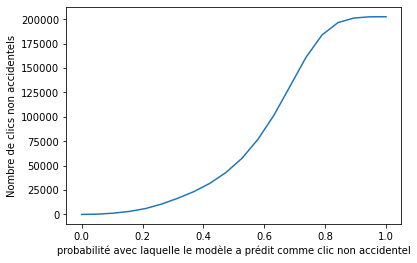

In [286]:
X=np.linspace(0,1,20)
y=[]
for i,x in enumerate(X):
    y.append(base_p[(base_p[1]<=x) & (base_p['confirmed']=='confirm')].shape[0])
plt.plot(X,y)
plt.ylabel("Nombre de clics non accidentels")
plt.xlabel("probabilité avec laquelle le modèle a prédit comme clic non accidentel")

Text(0.5, 0, 'probabilité avec laquelle le modèle a prédit comme clic accidentel')

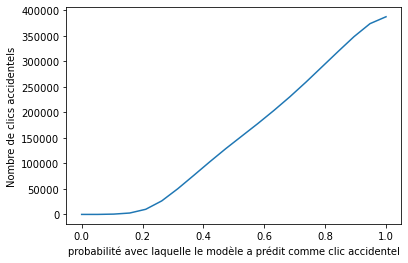

In [287]:
X=np.linspace(0,1,20)
y=[]
for i,x in enumerate(X):
    y.append(base_p[(base_p[0]<=x) & (base_p['confirmed']=='Nconfirm')].shape[0])
plt.plot(X,y)
plt.ylabel("Nombre de clics accidentels")
plt.xlabel("probabilité avec laquelle le modèle a prédit comme clic accidentel")

In [288]:
base['Y_pred']=np.where(base[1]>=0.5,1,0)

In [291]:
df=pd.concat([df, base[['Y_pred',1,0]]],axis=1)

In [292]:
df['Y']=np.where(df['confirmed']=='confirm',1,0)

### Perpectives pour la suite:
On regarde la performance globale de model_log1 pour les observations attachées à chaque device_type. Ceci nous indiquera quels sont les device_types dont les observations collent plus à ce modèle. 

Visualistation globale du modele sur le device_typeAndroid qui represente 358375 observations dans la base 


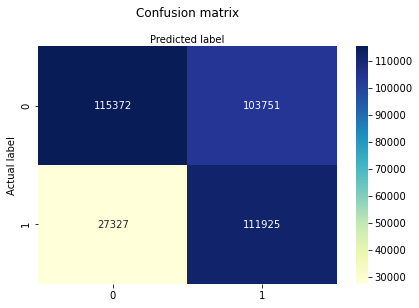

Accuracy: 0.6342434600627834
Precision: 0.5189497208776127
Recall: 0.8037586533766122
****************************************************
Visualistation globale du modele sur le device_typeDesktop qui represente 15272 observations dans la base 


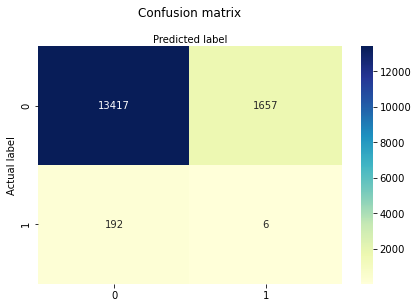

Accuracy: 0.8789287585123101
Precision: 0.0036079374624173183
Recall: 0.030303030303030304
****************************************************
Visualistation globale du modele sur le device_typeDesktop - Safari qui represente 48 observations dans la base 


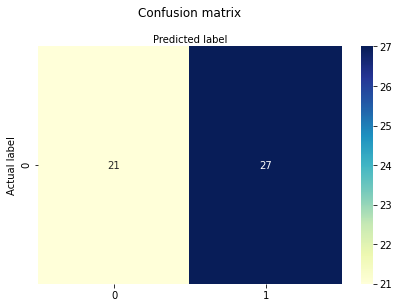

Accuracy: 0.4375
Precision: 0.0
Recall: 0.0
****************************************************
Visualistation globale du modele sur le device_typeMobile - Other qui represente 2420 observations dans la base 


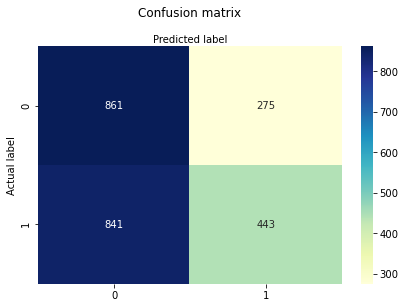

Accuracy: 0.5388429752066116
Precision: 0.616991643454039
Recall: 0.34501557632398755
****************************************************
Visualistation globale du modele sur le device_typeUnknown qui represente 51707 observations dans la base 


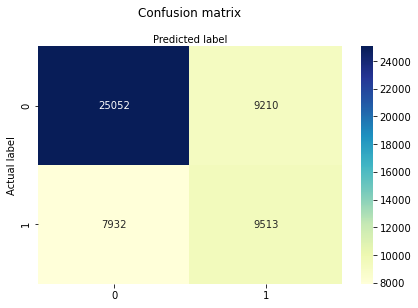

Accuracy: 0.6684781557622759
Precision: 0.5080916519788495
Recall: 0.5453138435081686
****************************************************
Visualistation globale du modele sur le device_typeiPad qui represente 45179 observations dans la base 


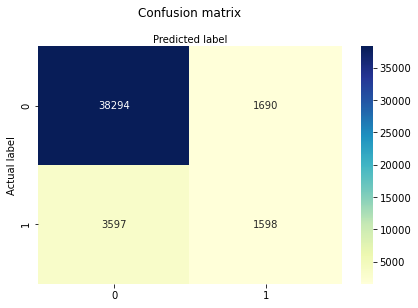

Accuracy: 0.8829766041745059
Precision: 0.4860097323600973
Recall: 0.3076034648700674
****************************************************
Visualistation globale du modele sur le device_typeiPhone qui represente 116867 observations dans la base 


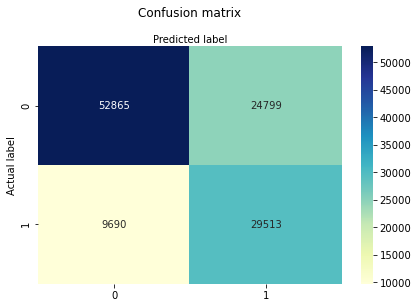

Accuracy: 0.704886751606527
Precision: 0.5433974075710708
Recall: 0.7528250389000842
****************************************************


In [309]:
for var in np.unique(df['device_type'].values).tolist():
    df_dev=df[df['device_type']==var]
    print(f'Visualistation globale du modele sur le device_type{var} qui represente { df_dev.shape[0]} observations dans la base ')
    cnf_matrix=pd.crosstab(df_dev['Y'],df_dev['Y_pred'])
    Vmatrice_confusion (cnf_matrix)    
    Performance(df_dev['Y'],df_dev['Y_pred'])
    print('****************************************************')
    

Pour les device_types Deskstop et iPad; model_log1 a des performances globale qui excèdent 85%. Il serait donc pas inutile d'estimer et d'entrainner ce modèle sur chacune de ces sous-bases 